# 📌 Insurance Premium Prediction MINMAX

**Author** : Thierry CAROLE <br>
**Date** : 22/04/2025

# 🧾Goals

The objectives of this challenge is to predict insurance premiums based on various factors.

https://www.kaggle.com/competitions/regression-with-an-insurance-dataset-bt-2-ds/overview

# Load libraries

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
import math
from scipy.stats import iqr
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor,Lasso,ElasticNet,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

from sklearn.metrics import make_scorer, mean_squared_log_error

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.svm import LinearSVR


# 📁 Loading data

In [2]:
# Determining training data path
data_path = "../data/raw_data/train.csv"

# Check if the file exists
if os.path.exists(data_path):
    data = pd.read_csv(data_path)
    print("File loaded successfully.")
else:
    print(f"File not found: {data_path}")
    sys.exit()  # Exits the script here

File loaded successfully.


In [3]:
# Make a copy of the data
data_copy = data.copy()

In [4]:
# Overview of the first lines
data.head(2)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0


In [5]:
# Remove empty space within column names
for col in data.columns:
    data.rename(columns = {col : col.replace(' ','_')},inplace=True)

In [6]:
# Let's delete the "id" column
data.drop(columns=['id'], inplace=True)

# 🔎 Data Mining (EDA)

**Objective**: To understand trends, distributions, missing values, etc.

## Info

In [7]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual_Income         1155051 non-null  float64
 3   Marital_Status        1181471 non-null  object 
 4   Number_of_Dependents  1090328 non-null  float64
 5   Education_Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health_Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy_Type           1200000 non-null  object 
 10  Previous_Claims       835971 non-null   float64
 11  Vehicle_Age           1199994 non-null  float64
 12  Credit_Score          1062118 non-null  float64
 13  Insurance_Duration    1199999 non-null  float64
 14  Policy_Start_Date     1200000 non-

## To date

In [8]:
# Convert "Policy_Start_Date" into DateTime
# data['Policy_Start_Date'] = pd.to_datetime(data['Policy_Start_Date'])
# data['Policy_Start_Date'] = pd.to_datetime(data['Policy_Start_Date'], format='%Y-%m-%d')
data['Policy_Start_Date'] = pd.to_datetime(data['Policy_Start_Date'])

In [9]:
data['Policy_Start_Date_year'] = data['Policy_Start_Date'].dt.year
data['Policy_Start_Date_month'] = data['Policy_Start_Date'].dt.month
data['Policy_Start_Date_day'] = data['Policy_Start_Date'].dt.day

In [10]:
data.drop(columns='Policy_Start_Date', inplace=True)

In [11]:
# Let's delete the "id" column
dropped = ['Number_of_Dependents','Education_Level','Smoking_Status','Gender','Policy_Start_Date_day','Vehicle_Age','Policy_Type']
data.drop(columns=dropped, inplace=True)

## Statistics

In [12]:
# Descriptive statistics
data.describe();

## Histograms

In [13]:
def plot_histplot_sns(df):
    """
    Plots Seaborn histograms of numerical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of numerical columns
    """
    #Only select numerical features 
    num_df = df.select_dtypes(include='number')
        
    vars = num_df.columns
    n = len(num_df.columns)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.histplot(data=num_df,kde=True, x=var, ax=axes[i])
        axes[i].set_title(var)

    # Delete unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [14]:
# # Display hist plots for numerical features.
# plot_histplot_sns(data)

## Count plots

In [15]:
def plot_countplot_sns(df):
        """
    Plots Seaborn countplots of categorical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of categorical columns
    """
        #Only select categorical features         
        cat_df = df.select_dtypes(exclude='number')

        vars = cat_df.columns
        n = len(cat_df.columns)
        cols = 3
        rows = math.ceil(n / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        axes = axes.flatten()

        for i, var in enumerate(vars):
            sns.countplot(data=cat_df, x=var, ax=axes[i])
            axes[i].set_title(var)

        # Delete unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

In [16]:
# # Display hist plots for numerical features.
# plot_countplot_sns(data)

## Check duplicates

In [17]:
def check_duplicates(df):
    """
    Counts duplicated rows. If any, function drops duplicated rows.
    Args:
        df (DataFrame): Raw data
    Returns:
        df (Dataframe) without duplicated rows
    """

    # Check number of rows before removing duplicates
    print(f"Number of rows : {len(df)}")

    # Compute the number of duplicated rows
    print(f"Number of duplicated rows : {df.duplicated().sum()}")

    if df.duplicated().sum()>0:
        # Remove duplicates
        df_no_duplicates = df.drop_duplicates()
        print("Duplicated rows have been removed")
        return df_no_duplicates
    else:
        return "No duplicated rows found !"    

In [18]:
# Check of duplicated values within dataset
check_duplicates(data)

Number of rows : 1200000
Number of duplicated rows : 7
Duplicated rows have been removed


,Age,Annual_Income,Marital_Status,Occupation,Health_Score,Location,Previous_Claims,Credit_Score,Insurance_Duration,Customer_Feedback,Exercise_Frequency,Property_Type,Premium_Amount,Policy_Start_Date_year,Policy_Start_Date_month
0,19.0,10049.0,Married,Self-Employed,22.598761,Urban,2.0,372.0,5.0,Poor,Weekly,House,2869.0,2023,12
1,39.0,31678.0,Divorced,NaN,15.569731,Rural,1.0,694.0,2.0,Average,Monthly,House,1483.0,2023,6
2,23.0,25602.0,Divorced,Self-Employed,47.177549,Suburban,1.0,NaN,3.0,Good,Weekly,House,567.0,2023,9
3,21.0,141855.0,Married,NaN,10.938144,Rural,1.0,367.0,1.0,Poor,Daily,Apartment,765.0,2024,6
4,21.0,39651.0,Single,Self-Employed,20.376094,Rural,0.0,598.0,4.0,Poor,Weekly,House,2022.0,2021,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,27316.0,Married,Unemployed,13.772907,Urban,NaN,372.0,3.0,Poor,Daily,Apartment,1303.0,2023,5
1199996,54.0,35786.0,Divorced,Self-Employed,11.483482,Rural,NaN,597.0,4.0,Poor,Weekly,Apartment,821.0,2022,9
1199997,19.0,51884.0,Divorced,NaN,14.724469,Suburban,0.0,NaN,6.0,Good,Monthly,Condo,371.0,2021,5
1199998,55.0,NaN,Single,NaN,18.547381,Suburban,1.0,407.0,4.0,Poor,Daily,Apartment,596.0,2021,9


## Correlation

### Correlation between numerical features

In [19]:
def create_correlation_heatmap(df): 
    """
    Plots correlation heatmap of numerical features.
    Args:
        df (DataFrame): Raw data
    Returns:
        Plot of correlation heatmap.
    """
    num_df = df.select_dtypes(include='number')
    correlation_matrix = num_df.corr()
    column_names = correlation_matrix.columns
    sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr"); 

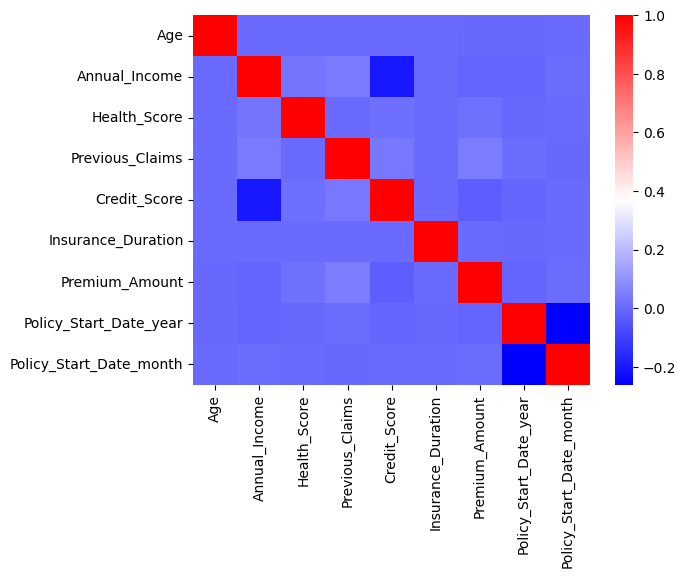

In [20]:
# Heatmap of pairwise correlations
create_correlation_heatmap(data)

### Correlation matrix

In [21]:
def create_pair_correlation_df(df):
        """
    Creates a dataframe listing pair correlations and absolute correlations
    Args:
        df (DataFrame): Raw data
    Returns:
        New df with pair correlations
    """
        num_df = df.select_dtypes(include='number')
    
        #Create a dataframe listing pair correlations and absolute correlations
        correlation_matrix = num_df.corr()

        # Converting the correlation matrix into a DataFrame
        corr_df = correlation_matrix.stack().reset_index()

        # Renaming the columns
        corr_df.columns = ['feature_1','feature_2', 'correlation']

        # Remove "self correlations"
        no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
        corr_df = corr_df[no_self_correlation]

        corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

        corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
        return corr_df

In [22]:
# Dataframe listing pair correlations and absolute correlations
corr_df = create_pair_correlation_df(data)
display(corr_df);

,feature_1,feature_2,correlation,absolute_correlation
79,Policy_Start_Date_month,Policy_Start_Date_year,-0.261312,0.261312
71,Policy_Start_Date_year,Policy_Start_Date_month,-0.261312,0.261312
37,Credit_Score,Annual_Income,-0.201423,0.201423
13,Annual_Income,Credit_Score,-0.201423,0.201423
57,Premium_Amount,Previous_Claims,0.046874,0.046874
...,...,...,...,...
5,Age,Insurance_Duration,-0.000064,0.000064
51,Insurance_Duration,Premium_Amount,-0.000028,0.000028
59,Premium_Amount,Insurance_Duration,-0.000028,0.000028
1,Age,Annual_Income,-0.000009,0.000009


In [23]:
def create_target_feature_corr(df, target_name):
    """
    Creates a dataframe listing correlations between target feature and the other features
    Args:
        - df (DataFrame): Raw data
        - target name : string
    Returns:
        New df with correlations between target and the other features
    """
    corr_df = create_pair_correlation_df(df)
    corr_target_feat_df = corr_df[corr_df["feature_1"] == target_name].head(40)
    return corr_target_feat_df

In [24]:
#Create a dataframe listing correlations between a feature and the target and absolute correlations
target_name = 'Premium_Amount'
corr_target_feat_df = create_target_feature_corr(data, target_name)
display(corr_target_feat_df)

,feature_1,feature_2,correlation,absolute_correlation
57,Premium_Amount,Previous_Claims,0.046874,0.046874
58,Premium_Amount,Credit_Score,-0.026014,0.026014
56,Premium_Amount,Health_Score,0.014704,0.014704
55,Premium_Amount,Annual_Income,-0.012390,0.012390
61,Premium_Amount,Policy_Start_Date_year,-0.011084,0.011084
62,Premium_Amount,Policy_Start_Date_month,0.006702,0.006702
54,Premium_Amount,Age,-0.002430,0.002430
59,Premium_Amount,Insurance_Duration,-0.000028,0.000028


## Check Missing data

In [25]:
# Function 
def show_missing_data(data):
    
        """
    Creates a dataframe listing the features and associated percentage of missing values.
    Args:
        - df (DataFrame): Raw data
    Returns:
        - New dataframe listing the features and associated percentage of missing values.
        - List of column names of features which have missing values
    """       
        
        # Counting the percentage of NaN for each column
        missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

        # missing_data
        missing_data = missing_data[missing_data > 0]

        #Missing data column names
        missing_cols = missing_data.index.values.tolist()

        #Show missing data in percent
        return missing_data, missing_cols

In [26]:
# Show Missing values in percentage
missing_perc_df, missing_cols = show_missing_data(data)
missing_perc_df

Previous_Claims       30.335750
Occupation            29.839583
Credit_Score          11.490167
Customer_Feedback      6.485333
Health_Score           6.173000
Annual_Income          3.745750
Age                    1.558750
Marital_Status         1.544083
Insurance_Duration     0.000083
dtype: float64

**Let's delete the rows with the least missing values of the numerical features that have the least correlation with the target.**

In [27]:
# Delete the missing rows of the numerical features that have the least correlation with the target.
subset_cols = ['Insurance_Duration','Age']
data.dropna(axis=0, subset=subset_cols, inplace=True)

In [28]:
# # Delete the missing rows of the numerical features that have the least correlation with the target.
# subset_cols = ['Insurance_Duration','Vehicle_Age','Number_of_Dependents','Age','Policy_Start_Date_day']
# data.dropna(axis=0, subset=subset_cols, inplace=True)

**Impute median values of numerical features the most correlated to target**

In [29]:
# Impute median value on remaining important numerical features correlated to target
for col in missing_cols:
    if col in data.select_dtypes(include='number').columns and col not in subset_cols:      
        # Add missing indicator
        data[f"{col}_missing"] = data[col].isna().astype(int)
        
        # Impute missing values (mean/median or custom)
        imputer = SimpleImputer(strategy='median')
        data[col] = imputer.fit_transform(data[[col]])

**Check missing values**

In [30]:
# Show Missing values in percentage
missing_perc_df, missing_cols = show_missing_data(data)
missing_perc_df

Occupation           29.825429
Customer_Feedback     6.476626
Marital_Status        1.543308
dtype: float64

**Impute most frequent values of categorical features the most correlated to target**

In [31]:
# Impute most frequent values of categorical features the most correlated to target
for col in missing_cols:
    if col in data.select_dtypes(exclude='number').columns:      
        # Add missing indicator
        data[f"{col}_missing"] = data[col].isna().astype(int)
        
        # Impute most used value
        data[col] = data[col].fillna(data[col].mode()[0])

In [32]:
# Show Missing values in percentage
missing_perc_df, missing_cols = show_missing_data(data)
missing_perc_df

Series([], dtype: float64)

In [33]:
missing_cols

[]

# Check correlation again

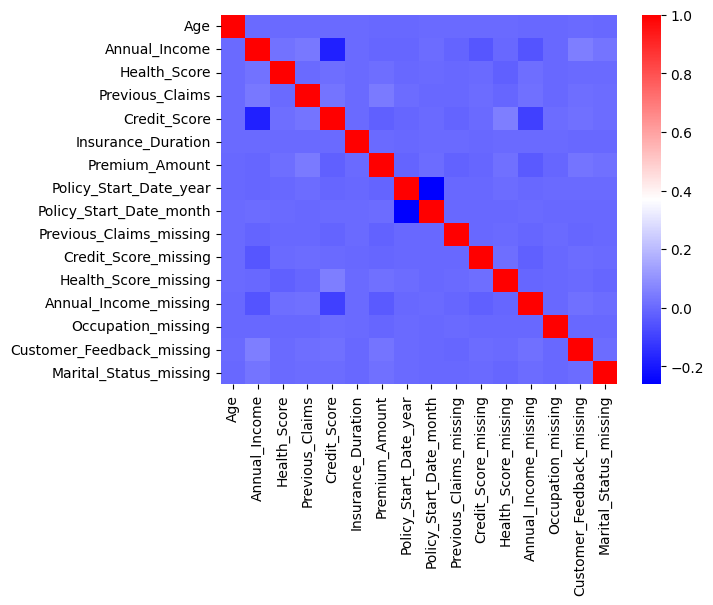

In [34]:
# Heatmap of pairwise correlations
create_correlation_heatmap(data)

In [35]:
#Create a dataframe listing correlations between a feature and the target and absolute correlations
target_name = 'Premium_Amount'
corr_target_feat_df = create_target_feature_corr(data, target_name)
display(corr_target_feat_df)

,feature_1,feature_2,correlation,absolute_correlation
99,Premium_Amount,Previous_Claims,0.039270,0.039270
108,Premium_Amount,Annual_Income_missing,-0.039192,0.039192
110,Premium_Amount,Customer_Feedback_missing,0.026552,0.026552
100,Premium_Amount,Credit_Score,-0.024572,0.024572
105,Premium_Amount,Previous_Claims_missing,-0.019256,0.019256
111,Premium_Amount,Marital_Status_missing,0.016738,0.016738
107,Premium_Amount,Health_Score_missing,0.016342,0.016342
98,Premium_Amount,Health_Score,0.014066,0.014066
103,Premium_Amount,Policy_Start_Date_year,-0.011354,0.011354
97,Premium_Amount,Annual_Income,-0.010013,0.010013


## Check outliers

### Visual check for outliers

In [36]:
def plot_boxplot_sns(df):
    """
    Plots Seaborn histograms of numerical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of numerical columns
    """
    #Only select numerical features 
    num_df = df.select_dtypes(include='number')
        
    vars = num_df.columns
    n = len(num_df.columns)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.boxplot(data=num_df, x=var, ax=axes[i])
        axes[i].set_title(var)

    # Delete unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [37]:
# # Display box plots for numerical features.
# plot_boxplot_sns(data);

In [38]:
# data.select_dtypes(include='number').columns;

### Numerical check for outliers

In [39]:
# def extract_cols_outliers(df):
#         """
#     Extract the columns with outliers.
#     Args:
#         df (DataFrame): Raw data
#     Returns:
#         - a list of numerical columns with outliers
#         - a list of nnumerical columns without outliers
#     """
#         # Identify the columns with outliers
#         numerical_columns_w_outliers = []
#         numerical_columns_no_outliers = []
        
#         num_df = df.select_dtypes(include='number')
#         numerical_columns = num_df.columns
        
#         for col in numerical_columns: 
#             # Calculate IQR
#             iqr_value = iqr(df[col],nan_policy='omit')
        
#             #Calculate 1st quartile
#             q1 = np.percentile(df[col],25)
        
#             #Calculate 3rd quartile
#             q3 = np.percentile(df[col],75)
        
#             #Calculate lower limit below which data point is considered an outlier
#             outlier_lim_low = q1 - 1.5 * iqr_value
        
#             #Calculate higher limit above which data point is considered an outlier
#             outlier_lim_high = q3 + 1.5 * iqr_value
            
#             #Calculate number of 'low' outliers
#             outlier_condition_low = df[col] < outlier_lim_low
#             number_outliers_low = len(df[outlier_condition_low][col])
            
#             #Calculate number of 'high' outliers
#             outlier_condition_high = df[col] > outlier_lim_high
#             number_outliers_high = len(df[outlier_condition_high][col])
            
#             #Calculate total number of outliers
#             number_outliers_total = number_outliers_low + number_outliers_high
            
#             #If any outliers in column, column is added to a list of columns with outliers
#             if number_outliers_total > 0:
#                 numerical_columns_w_outliers.append(col)
#             elif number_outliers_total == 0:
#                 numerical_columns_no_outliers.append(col)

#         return numerical_columns_w_outliers, numerical_columns_no_outliers

In [40]:
# numerical_columns_w_outliers, numerical_columns_no_outliers = extract_cols_outliers(data)

In [41]:
# numerical_columns_w_outliers

In [42]:
# numerical_columns_no_outliers

# ⚙️ Data preprocessing

## Scaling

### Columns with outliers

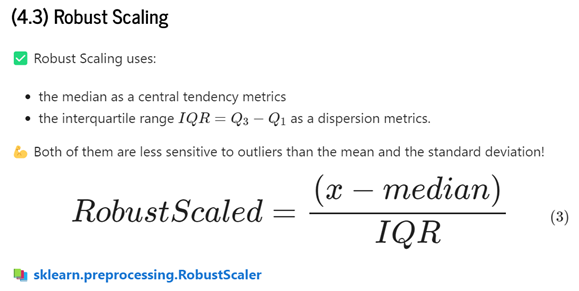

In [43]:
# numerical_columns_w_outliers.remove("Premium_Amount")

In [44]:
# # Describe columns with outliers
# data[numerical_columns_w_outliers].describe();

In [45]:
# #Instanciate, fit, transform with robust scaler
# rb_scaler = RobustScaler()
# data[numerical_columns_w_outliers] = rb_scaler.fit_transform(data[numerical_columns_w_outliers])

In [46]:
# # Describe columns with outliers after robust scaling
# data[numerical_columns_w_outliers].describe();

### Columns WITHOUT outliers

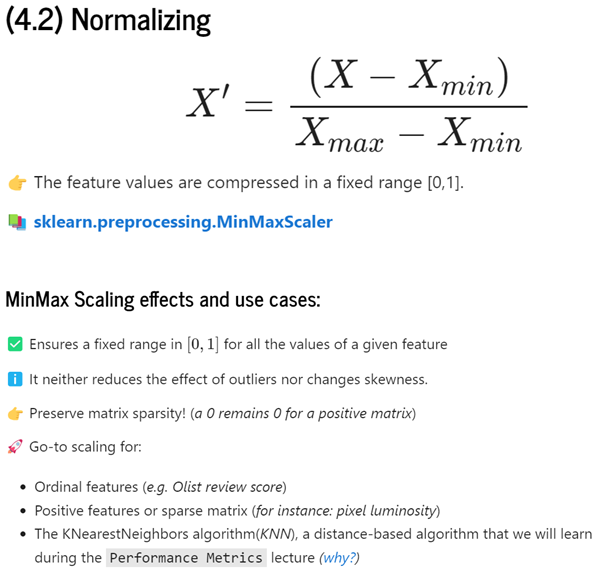


In [47]:
# # Describe columns with NO outliers
# data[numerical_columns_no_outliers].describe();

In [48]:
# #Instanciate, fit, transform with minmax scaler
# minmax_scaler = MinMaxScaler()
# data[numerical_columns_no_outliers] = minmax_scaler.fit_transform(data[numerical_columns_no_outliers])

In [49]:
# # Describe columns with NO outliers after minmax scaling
# data[numerical_columns_no_outliers].describe();

In [50]:
numerical_cols = data.select_dtypes(include='number').columns.tolist()
numerical_cols.remove('Premium_Amount')

In [51]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
data[numerical_cols] = minmax_scaler.fit_transform(data[numerical_cols])

## Encoding

In [52]:
# Extract categorical columns from original dataset
categorical_columns = data.select_dtypes(include = 'object').columns
categorical_columns;

### One hot encoder

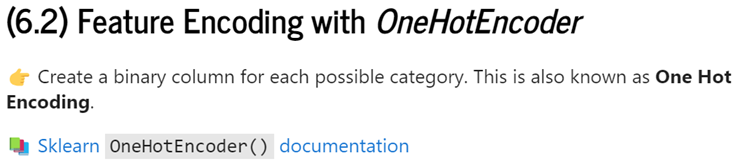

In [53]:
# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['Marital_Status', 'Occupation','Location','Exercise_Frequency','Property_Type']

In [54]:
# Instantiate, fit
ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
ohe_encoder.fit(data[categorical_columns_ohe])

#Transform 
data[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(data[categorical_columns_ohe]);
print(data.shape)

#Drop initial features
data.drop(columns=categorical_columns_ohe, inplace=True)
print(data.shape)

(1181294, 38)
(1181294, 33)


In [55]:
# # Instantiate, fit
# ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
# ohe_encoder.fit(data[categorical_columns_ohe])

# #Transform 
# data[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(data[categorical_columns_ohe]);
# print(data.shape)

# #Drop initial features
# data.drop(columns=categorical_columns_ohe, inplace=True)
# print(data.shape)

### Ordinal encoder

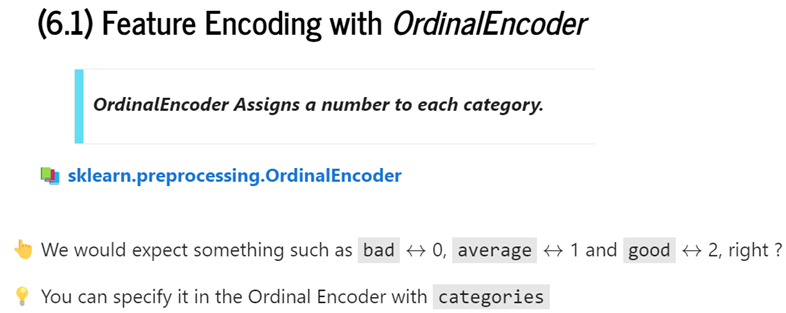

In [56]:
# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['Customer_Feedback']

In [57]:
# # Categorical columns to be encoded with OrdinalEncoder
# categorical_columns_ordinal = ['Policy_Type', 'Education_Level','Customer_Feedback']

In [58]:
# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)
Customer_Feedback_cat=['Poor','Average','Good']

ordered_categories = [Customer_Feedback_cat]

In [59]:
# # Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# # (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

# Policy_Type_cat=['Basic','Comprehensive','Premium']
# Education_Level_cat=['High School', "Bachelor's",'PhD',"Master's" ]
# Customer_Feedback_cat=['Poor','Average','Good']

# ordered_categories = [Policy_Type_cat, Education_Level_cat,Customer_Feedback_cat]

In [60]:
# Instantiate, fit using ordinal encoding
ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
ordinal_encoder.fit(data[categorical_columns_ordinal]);

#Transform
data[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(data[categorical_columns_ordinal])

print(data.shape)

(1181294, 33)


## Preprocessing pipeline

tbd

# 🧠 Modeling / Machine Learning

In [61]:
# Define X and y
target_name = 'Premium_Amount'
X = data.drop(columns= target_name)
y = data[target_name]

In [62]:
# Separating train set from test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display shapes
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_train : (826905, 32)
Shape of X_test : (354389, 32)
Shape of y_train : (826905,)
Shape of y_test : (354389,)


In [63]:
def root_mean_squared_log_error(y_test, y_pred):
        """
    Calcuates the root mean squared logarithmic error between real target values and predicted target values
    Args:
        - y_test: real target values
        - y_pred: predicted target values
    Returns:
        Root mean squared logarithmic error
    """
        return np.sqrt(mean_squared_log_error(y_test, y_pred))

# Wrapper to use in cros_val_score function (I want the root mean squared log error to be as small as possible)
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [64]:
%%time

# Selection of models to try out
linear_models = [LinearRegression(), 
                 SGDRegressor(random_state=42), 
                 Lasso(random_state=42),
                 ElasticNet(random_state=42),
                 Ridge(random_state=42)]

# linear_models = [LinearRegression(), 
#                  SGDRegressor(random_state=42), 
#                  Lasso(random_state=42),
#                  ElasticNet(random_state=42),
#                  Ridge(random_state=42),
#                  LinearSVR(random_state=42)]

rmsle_scores = {}

# Train and evaluate the models
for model in linear_models:
    rmsle = -cross_val_score(model, X_train, y_train, cv=5, scoring= rmsle_scorer).mean()
    rmsle_scores[str(model)[:str(model).find('(')]] = rmsle
    print(f"{model} is finished!")

# Formatting the results into a dataframe
rmsle_scores_df = pd.DataFrame(rmsle_scores, index=[0])
rmsle_scores_df = rmsle_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'Mean_score', 'index' : 'Model'})\
                                .sort_values('Mean_score', ascending=True)
display(rmsle_scores_df)

print("*****************************")
print(f"The best model from cross validation (in regard to scoring method) seems to be : {rmsle_scores_df.Model.head(1).values[0]}")
print("*****************************")

LinearRegression() is finished!
SGDRegressor(random_state=42) is finished!
Lasso(random_state=42) is finished!
ElasticNet(random_state=42) is finished!
Ridge(random_state=42) is finished!


,Model,Mean_score
0,LinearRegression,1.164629
4,Ridge,1.164629
1,SGDRegressor,1.165684
2,Lasso,1.166364
3,ElasticNet,1.171386


*****************************
The best model from cross validation (in regard to scoring method) seems to be : LinearRegression
*****************************
CPU times: user 1min 39s, sys: 3.29 s, total: 1min 42s
Wall time: 37.3 s


In [65]:
# Fit model
model = LinearRegression()
fitted_model = model.fit(X_train, y_train)

# Predictions
y_pred = fitted_model.predict(X_test)

root_mean_squared_log_error(y_test, y_pred)

np.float64(1.1616418047064327)

In [66]:
y_pred

array([1074.27209784, 1139.82371555, 1224.47229084, ..., 1083.07484875,
       1039.04784513, 1048.68101402], shape=(354389,))

# 📊 Results analysis / visualization

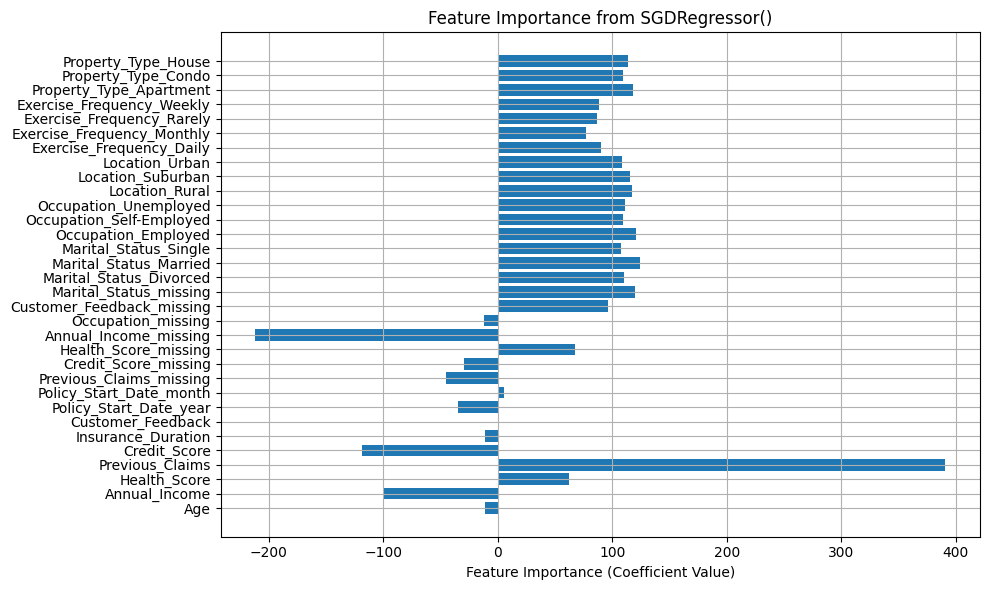

In [70]:
feature_names = [f"Feature {i}" for i in range(X.shape[1])]

# 2. Train an SGDRegressor
model = SGDRegressor()
model.fit(X, y)

# 3. Get feature importance (the model's coefficients)
importance = model.coef_

# 4. Plot
plt.figure(figsize=(10,6))
plt.barh(X.columns.tolist(), importance)
plt.xlabel('Feature Importance (Coefficient Value)')
plt.title(f'Feature Importance from {model}')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧪Conclusion and recommendations

# 📦 Appendices / references